### 1. Data Loader and Configurations

In [43]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf

import warnings
warnings.simplefilter("ignore")

In [44]:
BASE_DIR = 'basin_dataset_public' 
CFS_TO_CMS = 0.0283168  
FORCING_TYPE = 'nldas'
BAD_BASINS_FILE = 'basin_size_errors_10_percent.txt'

# Files for static features
FILES_TO_LOAD = [
    'camels_topo.txt',  # Elevation, Slope, Area
    'camels_soil.txt',  # Sand, Clay, Porosity
    'camels_clim.txt',  # Precip, Aridity, Snow Fraction
    'camels_vege.txt',  # Forest fraction, LAI
    'camels_geol.txt',  # Rock types, Permeability
    'camels_name.txt',  # Region (HUC), Names
    'camels_hydro.txt'  # Hydrological Signatures (Target behavior)
]

sns.set(style="ticks")
plt.rcParams['figure.figsize'] = (12, 6)

In [45]:
# --- Helper Functions to Load Time Series Data ---
def load_bad_basins_list():
    """Parses the basin_size_errors file safely, ignoring river names."""
    file_path = os.path.join(BASE_DIR, BAD_BASINS_FILE)
    if not os.path.exists(file_path): 
        return []
    
    try:
        bad_ids = []
        with open(file_path, 'r') as f:
            next(f) 
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2: 
                    bad_ids.append(parts[1])
        return bad_ids
    except: 
        return []

def get_all_basins():
    """Scans for streamflow files and extracts IDs."""
    search_path = os.path.join(BASE_DIR, 'usgs_streamflow', '**', '*_streamflow_qc.txt')
    files = glob.glob(search_path, recursive=True)
    basin_list = []

    for f in files:
        parts = f.split(os.sep)
        basin_list.append({'gauge_id': parts[-1].split('_')[0], 'region': parts[-2], 'flow_path': f})

    return pd.DataFrame(basin_list)

def load_basin_data(gauge_id, region):
    """
    Load all basins data and handles variations in column names (Mnth/Month/year)
    """
    # --- 1. Load Streamflow ---
    flow_path = os.path.join(BASE_DIR, 'usgs_streamflow', region, f'{gauge_id}_streamflow_qc.txt')
    
    try:
        df_flow = pd.read_csv(flow_path, delim_whitespace=True, header=None,
                              names=['gauge_id', 'Year', 'Month', 'Day', 'Q_cfs', 'QC'])
    except Exception as e: 
        return None

    # Ensure data is in correct datetime format
    df_flow['Date'] = pd.to_datetime(df_flow[['Year', 'Month', 'Day']])
    df_flow.set_index('Date', inplace=True)
    df_flow['Q_cms'] = df_flow['Q_cfs'].replace(-999, np.nan) * CFS_TO_CMS

    # --- 2. Load NLDAS Forcing ---
    forcing_path = os.path.join(BASE_DIR, 'basin_mean_forcing', FORCING_TYPE, region, 
                                f'{gauge_id}_lump_nldas_forcing_leap.txt')
    if not os.path.exists(forcing_path): 
        return None

    try:
        df_force = pd.read_csv(forcing_path, delim_whitespace=True, skiprows=3)
    except: 
        return None

    # Normalize columns
    # Map of known variations to standard names
    col_map = {
        'Mnth': 'Month', 'month': 'Month', 'mo': 'Month',
        'year': 'Year', 'yr': 'Year',
        'day': 'Day', 'dy': 'Day',
        'hr': 'Hour', 'hour': 'Hour',
        'prcp(mm/day)': 'PRCP', 'srad(w/m2)': 'SRAD', 
        'tmax(c)': 'Tmax', 'tmin(c)': 'Tmin', 'vp(pa)': 'Vp'
    }
    
    # Rename columns flexibly (case insensitive match if possible, but explicit map is safer)
    new_cols = {}
    for c in df_force.columns:
        # Strip whitespace
        clean_c = c.strip()
        # Check explicit map
        if clean_c in col_map:
            new_cols[c] = col_map[clean_c]
        # Check lower case map
        elif clean_c.lower() in col_map:
            new_cols[c] = col_map[clean_c.lower()]
        else:
            new_cols[c] = clean_c # Keep original if unknown
            
    df_force.rename(columns=new_cols, inplace=True)

    try:
        df_force['Date'] = pd.to_datetime(df_force[['Year', 'Month', 'Day']])
        df_force.set_index('Date', inplace=True)
    except KeyError as e:
        print(f"Skipping {gauge_id}: Missing date columns after rename. Found: {df_force.columns.tolist()}")
        return None

    # --- 4. Merge ---
    # Drop date columns from forcing to avoid duplicates
    cols_to_use = [c for c in df_force.columns if c not in ['Year', 'Month', 'Day', 'Hour']]
    df_merged = df_flow[['Q_cms', 'QC']].join(df_force[cols_to_use], how='inner')
    
    return df_merged

In [46]:
# --- Helper Function to Load Static Features ---
def load_static_features():   
    dfs = []
    
    for filename in FILES_TO_LOAD:
        file_path = os.path.join(BASE_DIR, filename)
        
        if not os.path.exists(file_path):
            print(f"[WARN] File not found: {filename}")
            continue
            
        try:
            df = pd.read_csv(file_path, sep=';')
            # 1. Clean Column Names 
            df.columns = [c.strip() for c in df.columns]
            
            # 2. Handle Gauge ID
            # It might be named 'gauge_id'
            if 'gauge_id' in df.columns:
                # Force to string and pad to 8 digits 
                df['gauge_id'] = df['gauge_id'].astype(str).str.zfill(8)
                df.set_index('gauge_id', inplace=True)
                
                # Drop duplicate columns if we are merging (like gauge_lat/lon might appear multiple times)
                # For now, we keep them and handle duplicates after concat
                dfs.append(df)
            else:
                print(f"[ERR] 'gauge_id' column missing in {filename}")
                
        except Exception as e:
            print(f"[ERR] Failed to load {filename}: {e}")

    if not dfs:
        return None

    # Merge all DataFrames on index (gauge_id)
    print("Merging attribute tables...")
    df_static = pd.concat(dfs, axis=1)
    
    # Remove duplicate columns (e.g., if gauge_lat appears in multiple files)
    df_static = df_static.loc[:, ~df_static.columns.duplicated()]
    
    print(f"Successfully loaded {df_static.shape[1]} attributes for {df_static.shape[0]} basins.")
    return df_static

In [47]:
bad_basins = load_bad_basins_list()
df_basins = get_all_basins()
df_basins['is_bad'] = df_basins['gauge_id'].isin(bad_basins)
valid_basins = df_basins[~df_basins['is_bad']].copy()

print(f"Total Basins Found: {len(df_basins)}")
print(f"Bad Basins (Area Error > 10%): {len(bad_basins)}")
print(f"Valid Basins for Analysis: {len(valid_basins)}")

Total Basins Found: 674
Bad Basins (Area Error > 10%): 66
Valid Basins for Analysis: 608


### 2. Single Basin Analysis

In [48]:
# Select a sample basin and load data 
sample_row = valid_basins[valid_basins['region'] == '01'].iloc[0]
print(f"Analyzing Basin: {sample_row['gauge_id']} (Region {sample_row['region']})")
df_single = load_basin_data(sample_row['gauge_id'], sample_row['region'])

print("\n[Data Structure]")
print(df_single.info())

Analyzing Basin: 01013500 (Region 01)

[Data Structure]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12784 entries, 1980-01-01 to 2014-12-31
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Q_cms    12692 non-null  float64
 1   QC       12784 non-null  object 
 2   Dayl(s)  12784 non-null  float64
 3   PRCP     12784 non-null  float64
 4   SRAD     12784 non-null  float64
 5   SWE(mm)  12784 non-null  float64
 6   Tmax     12784 non-null  float64
 7   Tmin     12784 non-null  float64
 8   Vp       12784 non-null  float64
dtypes: float64(8), object(1)
memory usage: 998.8+ KB
None


| Column      | Meaning                              | Typical Unit                                                  | Description                                                                                                                                                                                                                      |
| ----------- | ------------------------------------ | ------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Q_cms**   | Streamflow / Discharge               | m³/s (cms = cubic meters per second)                          | Observed river flow at the basin outlet. This is the **target variable** for hydrology models.                                                                                   |
| **QC**      | Quality Control Flag                 | – (text/categorical)                                          | Metadata indicating if a given `Q_cms` value is reliable, estimated, missing, or flagged by USGS. |
| **Dayl(s)** | Day length                           | Seconds                                                       | Number of daylight seconds in that day at the basin location.                                                                                                          |
| **PRCP**    | Precipitation                        | usually mm/day                                                | Total rainfall + snowfall water equivalent for that day. In NLDAS, precipitation is the main water-input forcing.                                    |
| **SRAD**    | Surface downward shortwave radiation | W/m²                                                          | Solar radiation energy reaching the land surface. Important for snowmelt and evapotranspiration (energy driver).                                                                                                                 |
| **SWE(mm)** | Snow Water Equivalent                | Millimeters of water                                          | The amount of water stored in the snowpack. `1 mm SWE = 1 kg/m² water`. Key for snow-dominated basins.                                                                                                                           |
| **Tmax**    | Daily maximum air temperature        | °C                                                            | Hottest temperature recorded (or simulated) that day in the basin.                                                                                                                                                               |
| **Tmin**    | Daily minimum air temperature        | °C                                                            | Coldest temperature recorded (or simulated) that day.                                                                                                                                         |
| **Vp**      | Vapor pressure                       | kPa (or hPa in some sources, but most NLDAS basin TS use kPa) | Atmospheric moisture pressure. Used for humidity calculations and evapotranspiration modeling. Higher `Vp` = more humid air.                                                                                                     |

In [49]:
missing_q = df_single['Q_cms'].isna().sum()
missing_p = df_single['PRCP'].isna().sum()

print(f"\n[Missing Data Stats]")
print(f"Total Days: {len(df_single)}")
print(f"Missing Flow Days: {missing_q} ({missing_q/len(df_single)*100:.2f}%)")
print(f"Missing Precip Days: {missing_p}")

# Check for gaps in index 
expected_range = pd.date_range(start=df_single.index.min(), end=df_single.index.max())
if len(expected_range) != len(df_single):
    print(f"WARNING: Index gap detected! Expected {len(expected_range)} days, got {len(df_single)}.")
else:
    print("Time Series Index is continuous (no missing dates, only missing values).")


[Missing Data Stats]
Total Days: 12784
Missing Flow Days: 92 (0.72%)
Missing Precip Days: 0
Time Series Index is continuous (no missing dates, only missing values).


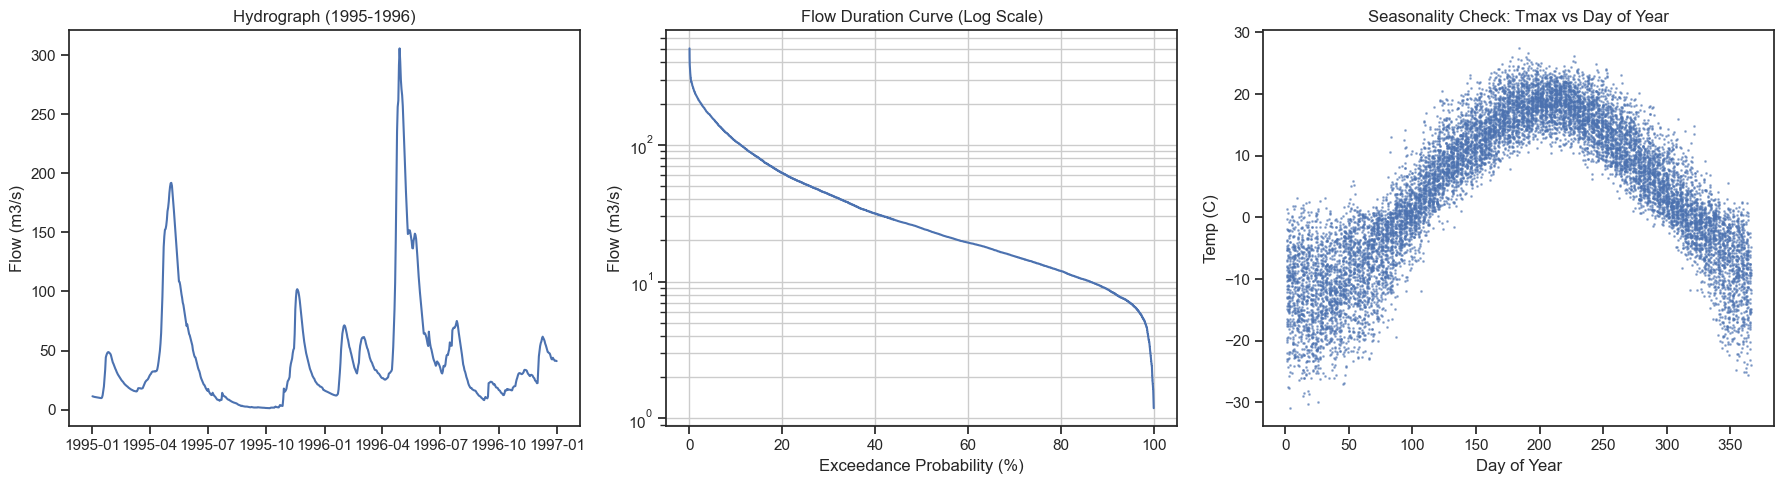

In [50]:
# Plotting graphs 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Hydrograph (Zoomed in 2 years)
# This graph plots the mean streamflow of the basin over 2 years. 
try:
    subset = df_single['1995':'1996']
    if subset.empty: raise ValueError("Empty slice")
    title_text = "Hydrograph (1995-1996)"
except:
    subset = df_single.iloc[:730]
    title_text = "Hydrograph (First 2 Years)"
    
axes[0].plot(subset.index, subset['Q_cms'], label='Flow')
axes[0].set_title(title_text)
axes[0].set_ylabel("Flow (m3/s)")

# 2. Flow Duration Curve (FDC) - Hydrology Standard
# This graph shows how often different river flow rates are equaled or exceeded over the full time record.
sorted_flow = np.sort(df_single['Q_cms'].dropna())[::-1]
exceedance = np.arange(1, len(sorted_flow)+1) / len(sorted_flow) * 100
axes[1].semilogy(exceedance, sorted_flow)
axes[1].set_title("Flow Duration Curve (Log Scale)")
axes[1].set_xlabel("Exceedance Probability (%)")
axes[1].set_ylabel("Flow (m3/s)")
axes[1].grid(True, which="both", ls="-")

# 3. Physical Consistency Check (Temp vs Season)
axes[2].scatter(df_single.index.dayofyear, df_single['Tmax'], s=1, alpha=0.5)
axes[2].set_title("Seasonality Check: Tmax vs Day of Year")
axes[2].set_xlabel("Day of Year")
axes[2].set_ylabel("Temp (C)")
plt.tight_layout()
plt.show()

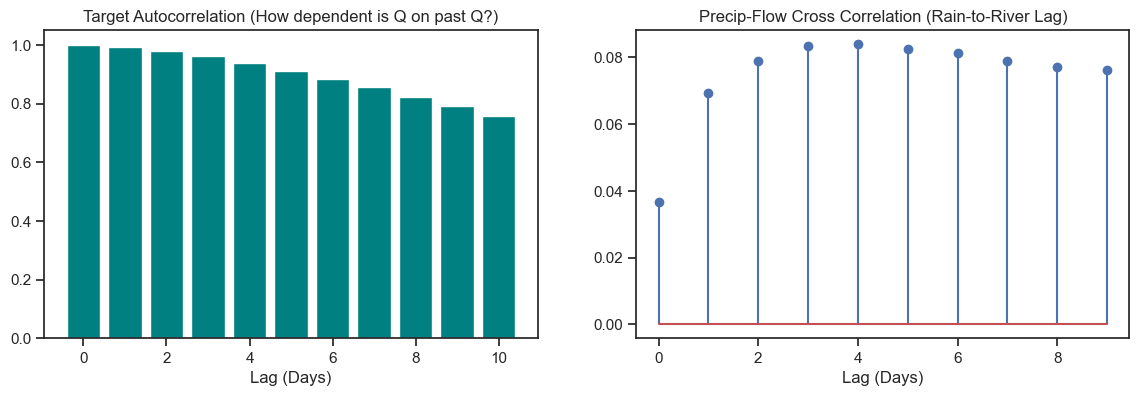

In [51]:
# Lag Analysis for Forecasting 
clean_df = df_single.dropna()
lags = 10

# Calculate correlations
auto_corr = acf(clean_df['Q_cms'], nlags=lags)
cross_corr = [clean_df['Q_cms'].corr(clean_df['PRCP'].shift(i)) for i in range(lags)]

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Autocorrelation (Memory)
ax[0].bar(range(len(auto_corr)), auto_corr, color='teal')
ax[0].set_title("Target Autocorrelation (How dependent is Q on past Q?)")
ax[0].set_xlabel("Lag (Days)")

# Cross Correlation (Response Time)
ax[1].stem(range(lags), cross_corr)
ax[1].set_title("Precip-Flow Cross Correlation (Rain-to-River Lag)")
ax[1].set_xlabel("Lag (Days)")
plt.show()

### 3. Global Aggregate Analysis (All Basins)

In [52]:
global_stats = []
MIN_VALID_TEMP = -60
MAX_VALID_TEMP = 60

In [53]:
count = 0
for idx, row in valid_basins.iterrows():
    # Load data
    df = load_basin_data(row['gauge_id'], row['region'])
    
    # Skip if load failed or time series is too short to be useful
    if df is None or len(df) < 365:
        continue 

    # Basic Stats
    total_days = len(df)
    missing_q = df['Q_cms'].isna().sum()
    
    # Integrity: Check for negative flows (Physics violation)
    neg_flows = (df['Q_cms'] < 0).sum()
    
    # Integrity: Check for frozen temperature sensors (Zero variance)
    if 'Tmax' in df.columns:
        temp_var = df['Tmax'].var()
    else:
        temp_var = np.nan # Handle cases where temp might be missing
    
    # Hydrology: Calculate Mean Flow and CV (Coefficient of Variation)
    mean_q = df['Q_cms'].mean()
    std_q = df['Q_cms'].std()
    cv_q = std_q / mean_q if mean_q > 0 else 0
    
    # Lag 1 Autocorrelation (Flashiness proxy)
    # Using simple pandas corr for speed
    lag1_corr = df['Q_cms'].corr(df['Q_cms'].shift(1))

    global_stats.append({
        'gauge_id': row['gauge_id'],
        'region': row['region'],
        'missing_pct': (missing_q / total_days) * 100,
        'negative_q_count': neg_flows,
        'mean_flow_cms': mean_q,
        'cv_flow': cv_q,
        'temp_variance': temp_var,
        'lag1_autocorr': lag1_corr
    })
    
    count += 1
    # Print progress every 50 basins
    if count % 50 == 0: print(f"Processed {count} basins...")

df_global = pd.DataFrame(global_stats)

print("\n[Global Data Quality Summary]")
# Show key statistics for the whole dataset
print(df_global.describe().T[['mean', 'min', '50%', 'max']])

Processed 50 basins...
Processed 100 basins...
Processed 150 basins...
Processed 200 basins...
Processed 250 basins...
Processed 300 basins...
Processed 350 basins...
Processed 400 basins...
Processed 450 basins...
Processed 500 basins...
Processed 550 basins...
Processed 600 basins...

[Global Data Quality Summary]
                       mean        min        50%         max
missing_pct        0.851367   0.000000   0.328536   17.873905
negative_q_count   0.000000   0.000000   0.000000    0.000000
mean_flow_cms      9.590608   0.041152   3.950541  242.008689
cv_flow            2.545703   0.110201   1.872019   26.589845
temp_variance     87.723962  12.350788  84.275011  521.110899
lag1_autocorr      0.713481   0.063916   0.730030    0.997629


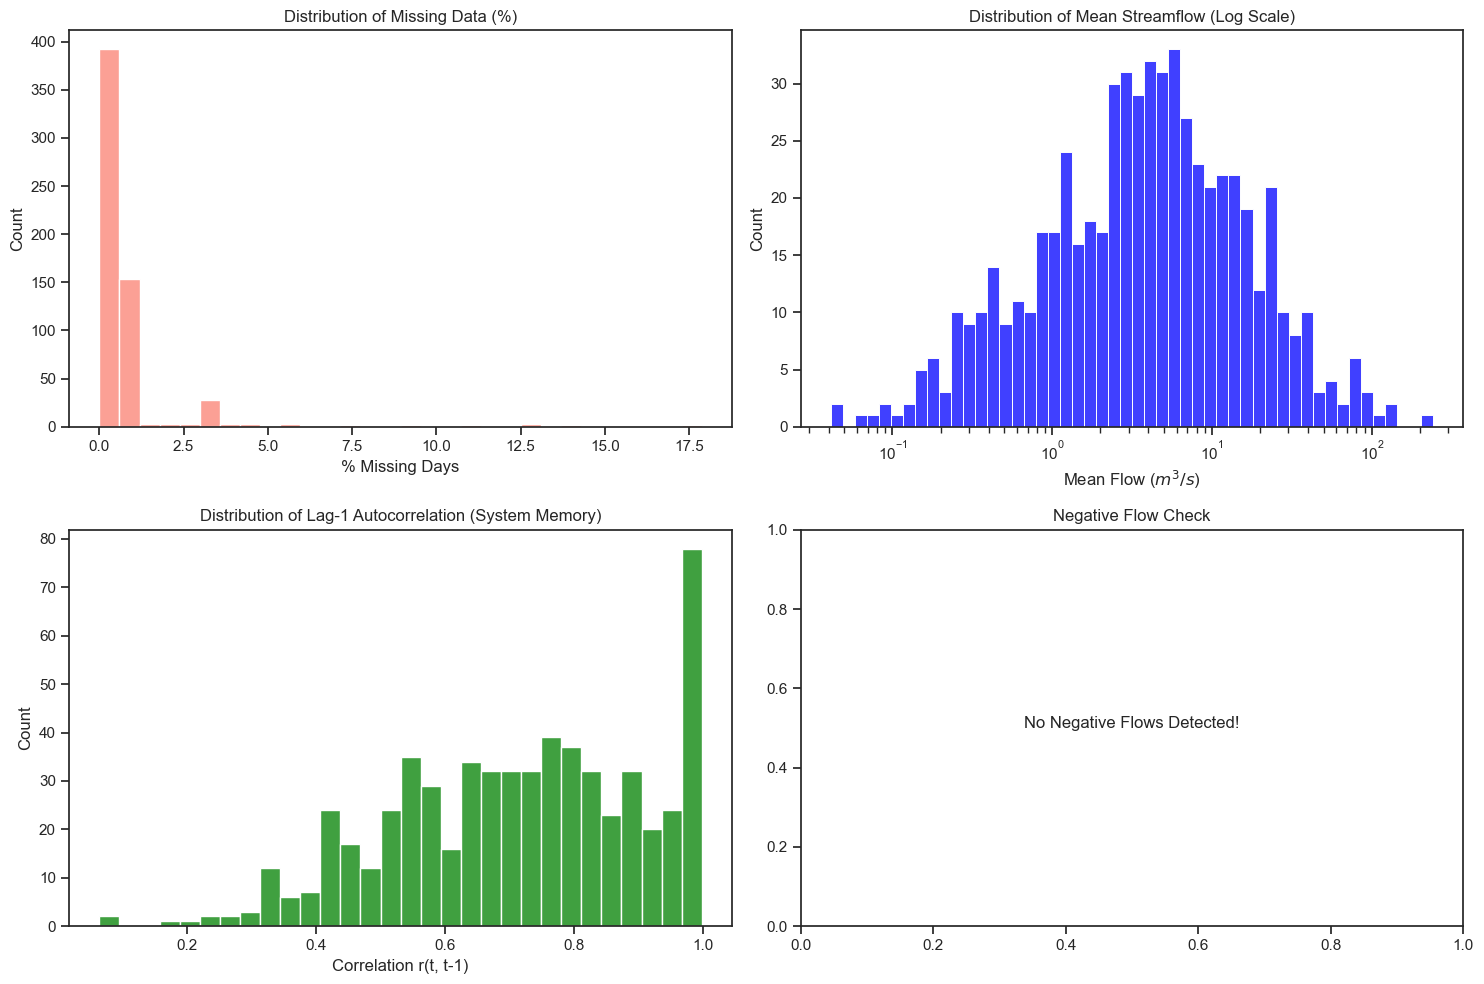

In [54]:
if not df_global.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Missing Data Histogram
    sns.histplot(df_global['missing_pct'], bins=30, ax=axes[0,0], color='salmon')
    axes[0,0].set_title("Distribution of Missing Data (%)")
    axes[0,0].set_xlabel("% Missing Days")

    # 2. Basin Scale (Mean Flow)
    # We use log scale because river sizes follow a power law
    sns.histplot(df_global['mean_flow_cms'], bins=50, log_scale=True, ax=axes[0,1], color='blue')
    axes[0,1].set_title("Distribution of Mean Streamflow (Log Scale)")
    axes[0,1].set_xlabel("Mean Flow ($m^3/s$)")

    # 3. Hydrologic Behavior (Flashiness)
    # Low Lag1 correlation = Flashy (harder to predict). High = Stable.
    sns.histplot(df_global['lag1_autocorr'], bins=30, ax=axes[1,0], color='green')
    axes[1,0].set_title("Distribution of Lag-1 Autocorrelation (System Memory)")
    axes[1,0].set_xlabel("Correlation r(t, t-1)")

    # 4. Check for Negative Flows
    has_neg = df_global[df_global['negative_q_count'] > 0]
    if not has_neg.empty:
        sns.scatterplot(data=has_neg, x='gauge_id', y='negative_q_count', ax=axes[1,1], color='red')
        axes[1,1].set_title(f"Basins with Negative Flows (N={len(has_neg)})")
    else:
        axes[1,1].text(0.5, 0.5, "No Negative Flows Detected!", ha='center', fontsize=12)
        axes[1,1].set_title("Negative Flow Check")

    plt.tight_layout()
    plt.show()

### 4. Static Features Analysis

In [55]:
df_static = load_static_features()

Merging attribute tables...
Successfully loaded 59 attributes for 671 basins.


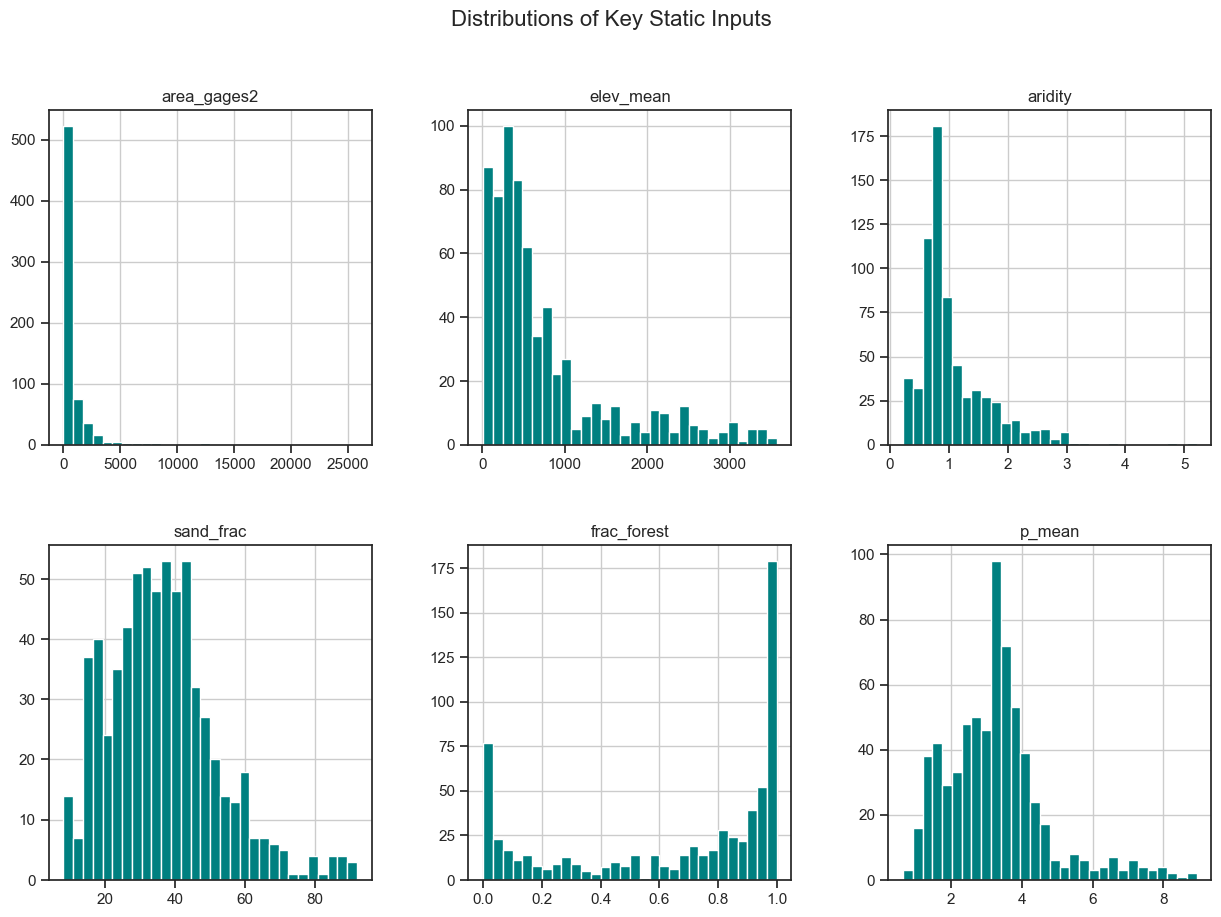

In [56]:
# Check features distribution
# These are the most critical inputs for an LSTM
key_features = [
    'area_gages2',  # Catchment Size (km2)
    'elev_mean',    # Elevation (m)
    'aridity',      # PET / Precip (Climate Index)
    'sand_frac',    # Soil property (Infiltration)
    'frac_forest',  # Vegetation (Interception)
    'p_mean'        # Mean Precipitation
]

# Filter to ensure columns exist
plot_feats = [f for f in key_features if f in df_static.columns]

if plot_feats:
    df_static[plot_feats].hist(bins=30, figsize=(15, 10), color='teal', layout=(2, 3))
    plt.suptitle("Distributions of Key Static Inputs", fontsize=16)
    plt.show()

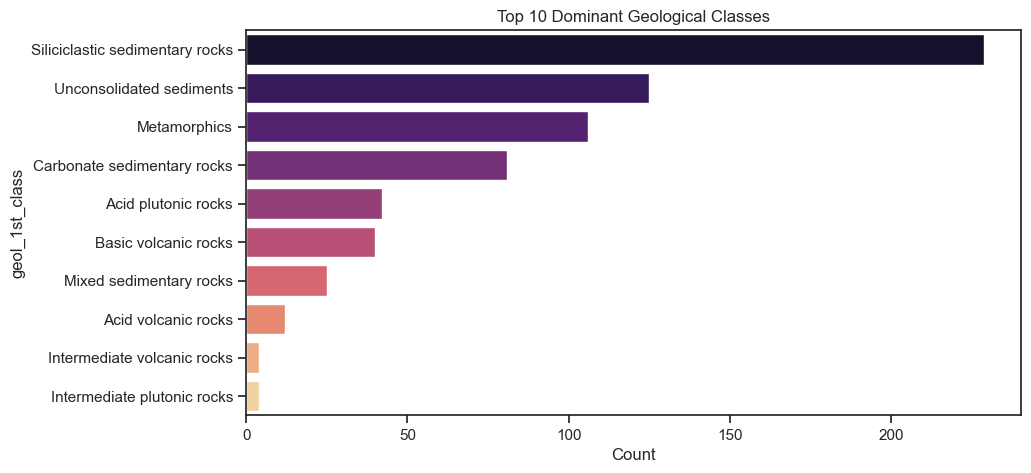

In [57]:
# Shows most popular rock types
if 'geol_1st_class' in df_static.columns:
    plt.figure(figsize=(10, 5))
    top_rocks = df_static['geol_1st_class'].value_counts().head(10)
    sns.barplot(y=top_rocks.index, x=top_rocks.values, palette='magma')
    plt.title("Top 10 Dominant Geological Classes")
    plt.xlabel("Count")
    plt.show()

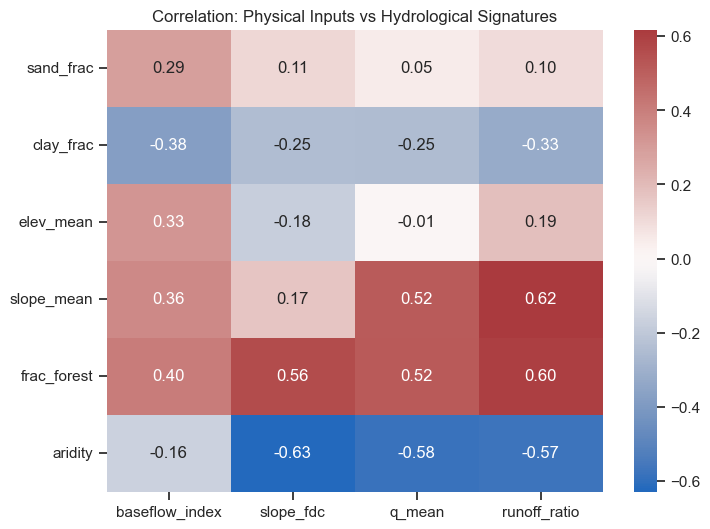

In [58]:
# --- CORRELATIONS: PHYSICS VS HYDROLOGY ---
# Does the physics explain the behavior?
# We correlate Physical Attributes (Soil/Topo) vs Hydrological Signatures (Baseflow/Flashiness)

# 'baseflow_index': High means steady flow (groundwater). Low means flashy.
# 'slope_fdc': Slope of Flow Duration Curve (Steep = Flashy).

target_sigs = ['baseflow_index', 'slope_fdc', 'q_mean', 'runoff_ratio']
input_attrs = ['sand_frac', 'clay_frac', 'elev_mean', 'slope_mean', 'frac_forest', 'aridity']

# Intersection of existing columns
valid_targets = [c for c in target_sigs if c in df_static.columns]
valid_inputs = [c for c in input_attrs if c in df_static.columns]

if valid_targets and valid_inputs:
    # Calculate Correlation
    corr_matrix = df_static[valid_inputs + valid_targets].corr()
    
    # Slice the matrix to show Inputs vs Targets
    subset_corr = corr_matrix.loc[valid_inputs, valid_targets]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(subset_corr, annot=True, fmt=".2f", cmap='vlag', center=0)
    plt.title("Correlation: Physical Inputs vs Hydrological Signatures")

## Insights from Exploratory Hydrology Graphs → Required Preprocessing for LSTM Model
**Goal:** avoid scale dominance, capture temporal memory, handle missing data, and encode physical & seasonal signals explicitly.

### 1. Hydrographs & Flow Duration Curves
- **Massive scale variance:** streamflow magnitudes differ across basins by several orders (e.g., 1000 m³/s vs 5 m³/s). Training the model on raw values would cause the loss to be dominated by large basins, leading the model to **ignore smaller basins** during optimization.
  → **Must normalize per basin**, recommended method: **Basin-Specific Z-Score Normalization** applied to the target (streamflow).
- **Seasonality is strong:** flow and temperature show clear yearly periodic patterns.
  → Convert timestamp into **cyclical features (sin/cos day-of-year)** so the model can learn seasonality as a continuous periodic signal instead of treating dates as unrelated scalar values.

### 2. Lag Analysis & Cross-Correlation
- **High autocorrelation ("memory"):** correlation at Lag 1 is > 0.9 and decays slowly over time.
  → The model input should explicitly include **recent streamflow history**, meaning LSTM sequences must have sufficient **lookback window length (sequence length)** to leverage this persistence.
- **Non-immediate rainfall response:** precipitation–flow correlation peaks around **Lag 3 to Lag 5**.
  → Rain often needs 3–5 days to propagate to rivers via runoff & routing processes. To predict future flow at **t+2 days**, the input sequence must be long enough to still "see" rainfall that occurred several days earlier.
  → Recommended LSTM sequence window: **30–60 days** to capture both short lags and broader hydrological context.

### 3. Global Basin Distributions
- **Missing data exists but limited:** only a few basins exceed 5% missing values.
  → To ensure stable learning, **exclude basins with > 10% missing data**.
  → Remaining basins should fill gaps using **linear interpolation** (good for continuous hydrological time series without abrupt breakpoints).
- **Streamflow distribution is log-normal:** heavy right skew is expected in natural discharge patterns.
  → This further supports applying **normalization or log-transformation** to the target prior to training to prevent instability from extreme values.

### 4. Static Feature Correlations (Physical Signals)
- Correlation heatmaps reveal **meaningful environmental relationships** (e.g., aridity vs runoff ratio ≈ −0.57), proving static features encode real hydrological behavior.
  → These are **valid predictive inputs** and worth keeping as model features.
- **Geological categorical classes have too many labels**, increasing model complexity without guaranteed gain.
  → Since soil texture variables like `sand_frac` and `clay_frac` are already strong **numeric proxies for geology**, we can **drop categorical geology columns for now** to simplify the model while preserving the same physical signal with continuous features.

### 5. Skewed Static Attributes
- Basin area (`area_gages2`) is **highly skewed**, with very large basins being rare but extreme.
  → Apply **log-transformation before normalization**, ensuring the feature becomes more Gaussian and better behaved for learning.

---

✅ Summary of required transforms:
| Issue | Why it matters | Solution |
|---|---|---|
| Flow scale dominance | small basins get ignored | z-score **per basin** (or log) on targets |
| Seasonality | yearly cycles must be learnable | sin/cos day-of-year encoding |
| Temporal memory | past flow is strongest predictor | include recent history in LSTM sequences |
| Rainfall delay | signal is lagged 3–5 days | 30–60 day lookback window |
| Missing values | harms training stability | remove bad basins, linear interp for rest |
| Feature complexity | too many geology labels | replace with numeric soil proxies |
| Skewed area feature | poor gradient behavior | log-transform then normalize |